In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [31]:
print(train_df.head())  # Display the first few rows
print(train_df.info())  # Summary of the dataset
print(train_df.describe())  # Basic statistics of the dataset
print(train_df.shape)  # Dimensions of the dataset


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
                 id      target
coun

In [32]:
# Step 4: Handle missing values
print(train_df.isnull().sum()) 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [33]:
# Drop rows with missing values
train_df = train_df.dropna()

In [34]:
# Step 5: Data preprocessing

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
def preprocess_text(text):
    # Remove special characters and links
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Tokenization and lowercase conversion
    text = text.lower()
    words = nltk.word_tokenize(text)

    # Remove stopwords and apply stemming
    words = [stemmer.stem(word) for word in words if word not in stopwords]
  
    return " ".join(words)

In [36]:
nltk.download('punkt')

train_df['preprocessed_text'] = train_df['text'].apply(preprocess_text)
test_df['preprocessed_text'] = test_df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


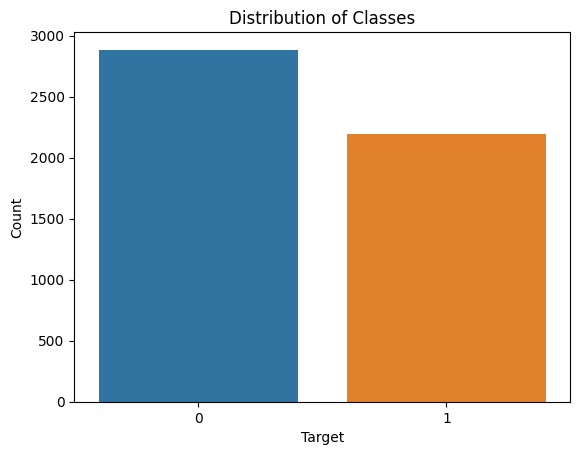

In [37]:
# Step 6: Data visualization
# Visualize the distribution of classes
sns.countplot(x='target', data=train_df)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

In [38]:
# Word frequency analysis
from collections import Counter
words = ' '.join(train_df['preprocessed_text']).split()
word_freq = Counter(words)
common_words = word_freq.most_common(20)

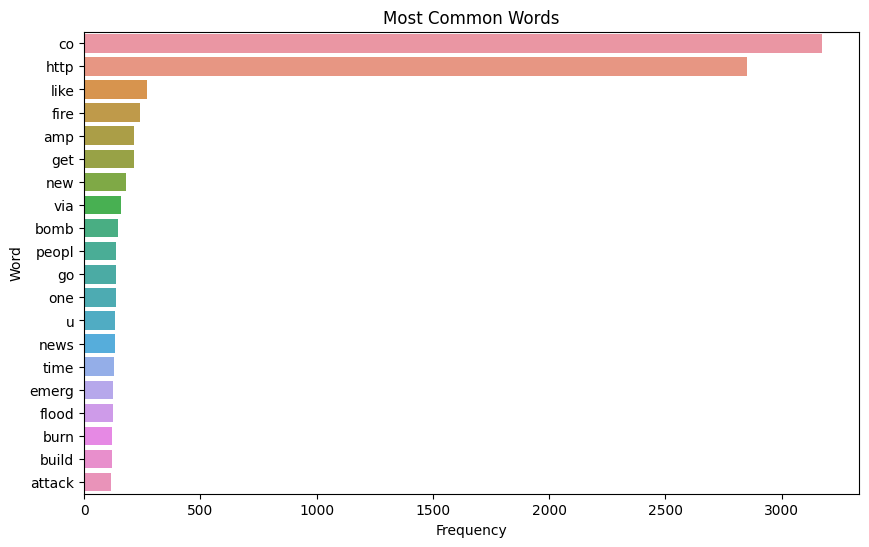

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in common_words],
            y=[word[0] for word in common_words])
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Most Common Words')
plt.show()

In [40]:
# Step 7: Feature engineering (if needed)
# Example: Extract word count as a feature
train_df['word_count'] = train_df['preprocessed_text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['preprocessed_text'].apply(lambda x: len(x.split()))

In [41]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x))
test_df['text_length'] = test_df['text'].apply(lambda x: len(x))

# Example 2: Presence of Keywords
train_df['has_keyword'] = train_df['keyword'].apply(lambda x: 0 if pd.isnull(x) else 1)
test_df['has_keyword'] = test_df['keyword'].apply(lambda x: 0 if pd.isnull(x) else 1)

# Example 3: Presence of Location
train_df['has_location'] = train_df['location'].apply(lambda x: 0 if pd.isnull(x) else 1)
test_df['has_location'] = test_df['location'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [43]:
X = train_df['preprocessed_text']
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

In [45]:
# Model 1: Logistic Regression
lr_model = LogisticRegression(C=1.0, max_iter=1000)
lr_model.fit(X_train_vec, y_train)
lr_preds = lr_model.predict(X_val_vec)

In [46]:
# Model 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_vec, y_train)
rf_preds = rf_model.predict(X_val_vec)


In [47]:
# Model 3: Gradient Boosting (XGBoost)
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_vec, y_train)
xgb_preds = xgb_model.predict(X_val_vec)

In [48]:
# Evaluate model performance
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

In [49]:
# Evaluate Logistic Regression
lr_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_model(y_val, lr_preds)

# Evaluate Random Forest
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(y_val, rf_preds)

# Evaluate XGBoost
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = evaluate_model(y_val, xgb_preds)



In [50]:
# Print the evaluation results
print("Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}\n")

print("Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}\n")

print("XGBoost Results:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")

Logistic Regression Results:
Accuracy: 0.7844
Precision: 0.7761
Recall: 0.6995
F1-Score: 0.7358

Random Forest Results:
Accuracy: 0.6683
Precision: 0.9901
Recall: 0.2294
F1-Score: 0.3724

XGBoost Results:
Accuracy: 0.7303
Precision: 0.7755
Recall: 0.5229
F1-Score: 0.6247


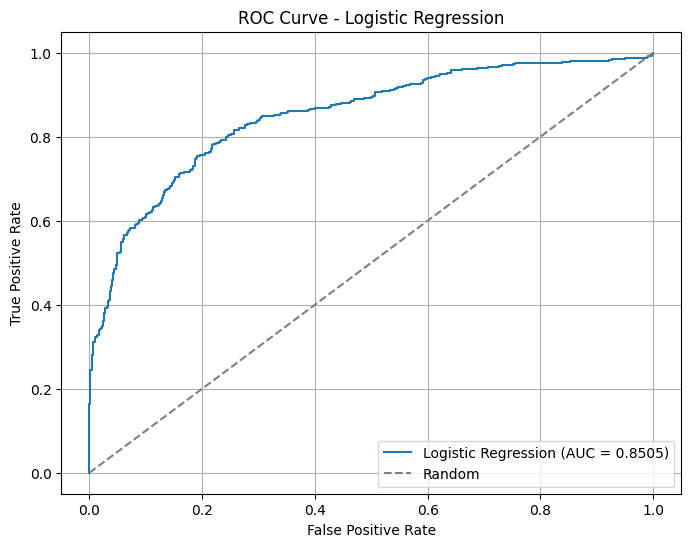

In [51]:

from sklearn.metrics import roc_curve, roc_auc_score

# Calculate predicted probabilities for the positive class
lr_probs = lr_model.predict_proba(X_val_vec)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_val, lr_probs)

# Calculate the AUC score
auc = roc_auc_score(y_val, lr_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [52]:
# Preprocess the test set
test_df['preprocessed_text'] = test_df['text'].apply(preprocess_text)

# Vectorize the test set using the same vectorizer used for training
X_test_vec = vectorizer.transform(test_df['preprocessed_text'])

# Make predictions on the test set using the trained model
test_preds = lr_model.predict(X_test_vec)

# Prepare the submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_preds})

# Save the submission file as CSV
submission_df.to_csv('submission.csv', index=False)
